# DS598 Final Project

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, matthews_corrcoef, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, make_scorer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
# import lightgbm as lgb
from pygam import LogisticGAM
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data Cleaning

In [7]:
Survival = pd.read_csv('dataset.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'dataset.csv'

In [4]:
Survival.shape

NameError: name 'Survival' is not defined

In [1]:
pd.set_option('display.max_columns', None)
Survival.head(20)
# pd.reset_option('display.max_columns')

NameError: name 'pd' is not defined

In [392]:
Survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [5]:
# remove column"Unnamed:83"
Survival.drop('Unnamed: 83', axis = 1, inplace = True)

In [6]:
# Calculate the proportion of NA
missing_percentage = (Survival.isnull().sum().sum() / (Survival.shape[0] * Survival.shape[1])) * 100

print("Percentage of missing values in the entire dataset: {:.2f}%".format(missing_percentage))
# dividing the total number of missing values by the total number of cells in the dataset

Percentage of missing values in the entire dataset: 2.55%


In [7]:
# Count the number of rows with NA values
rows_with_na = Survival[Survival.isnull().any(axis=1)].shape[0]

# Get the total number of rows
total_rows = Survival.shape[0]

# Calculate the percentage
percentage_rows_with_na = (rows_with_na / total_rows) * 100

print("Percentage of rows containing NA values in the total number of rows: {:.2f}%".format(percentage_rows_with_na))

Percentage of rows containing NA values in the total number of rows: 37.92%


#### Imputation of missing values

In [377]:
# Impute missing values with average value (Continious variables)
continuous_cols = ['age', 'bmi', 'pre_icu_los_days', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache',
                    'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache, ' ]

imputer = SimpleImputer(strategy='mean')

Survival_imputed = imputer.fit_transform(Survival[continuous_cols])

Survival[continuous_cols] = Survival_imputed

In [378]:
# Change class
object_cols = ['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'arf_apache', 'intubated_apache',  ]
Survival[object_cols] = Survival[object_cols].astype('category')



# EDA

In [398]:
Survival['ethnicity'].unique()

['Caucasian', NaN, 'Hispanic', 'African American', 'Asian', 'Native American', 'Other/Unknown']
Categories (6, object): ['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other/Unknown']

In [399]:
Survival['icu_admit_source'].unique()

['Floor', 'Accident & Emergency', 'Operating Room / Recovery', 'Other Hospital', 'Other ICU', NaN]
Categories (5, object): ['Accident & Emergency', 'Floor', 'Operating Room / Recovery', 'Other Hospital', 'Other ICU']

In [400]:
Survival['icu_stay_type'].unique()

['admit', 'readmit', 'transfer']
Categories (3, object): ['admit', 'readmit', 'transfer']

In [401]:
Survival['icu_type'].unique()

['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU', 'Cardiac ICU', 'CSICU']
Categories (8, object): ['CCU-CTICU', 'CSICU', 'CTICU', 'Cardiac ICU', 'MICU', 'Med-Surg ICU', 'Neuro ICU', 'SICU']

In [402]:
Survival['apache_2_bodysystem'].unique()

array(['Cardiovascular', 'Respiratory', 'Metabolic', 'Trauma',
       'Neurologic', 'Gastrointestinal', 'Renal/Genitourinary', nan,
       'Undefined diagnoses', 'Haematologic', 'Undefined Diagnoses'],
      dtype=object)

In [403]:
Survival.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,hospital_death
count,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,91713.000000,91713.000000,91713.000000,90998.000000,89812.000000,89812.000000,90676.000000,89812.000000,90835.000000,90998.000000,90719.000000,90479.000000,87605.000000,90998.000000,91548.000000,91548.000000,90673.000000,90673.000000,91568.000000,91568.000000,91493.000000,91493.000000,90234.000000,90234.000000,91328.000000,91328.000000,91380.000000,91380.000000,91554.000000,91554.00000,90686.000000,90686.000000,89389.000000,89389.000000,88094.000000,88094.000000,84363.000000,84363.000000,88923.000000,88923.000000,87074.000000,87074.000000,82629.000000,82629.000000,87356.000000,87356.000000,87528.000000,87528.000000,88102.000000,88102.000000,84372.000000,84372.000000,85906.000000,85906.000000,82128.000000,82128.000000,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,84.028340,185.401739,558.216377,0.201106,0.027979,3.465049,5.471195,0.009528,3.994778,99.707932,0.151223,88.015873,25.811007,36.414472,0.325721,88.491873,50.161314,88.610513,50.242597,103.000568,70.321848,104.651339,64.871859,104.590454,64.941541,28.882774,12.846279,99.241836,90.454826,148.339745,96.92387,148.235549,96.993313,37.284201,36.268391,75.354508,62.838150,75.805934,63.270616,92.229198,83.663720,91.612950,79.400028,91.594126,79.709315,22.633614,17.211525,98.044637,95.174310,133.247395,116.362296,133.054686,116.549625,174.638023,114.380940,4.251594,3.934658,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,0.086302
std,37795.088538,37811.252183,62.854406,16.383883,8.118970,0.387271,10.795378,228.989661,2.487756,25.011497,85.267612,460.477835,0.400829,0.164912,0.951715,1.288376,0.097148,1.560166,30.870502,0.358268,42.032412,15.106312,0.833496,0.468646,19.798379,13.317586,19.793743,13.341521,22.017346,17.115903,20.808358,15.679680,20.701171,15.701305,10.701973,5.064943,1.794181,10.030069,25.733259,20.67793,25.792453,20.705016,0.693287,0.745147,18.409190,16.363229,18.481826,16.422063,21.823704,20.279869,20.533174,19.130590,20.552018,19.236507,7.515043,6.072588,3.212934,6.625227,27.556986,26.510637,27.679751,26.623528,86.687955,38.273013,0.667355,0.579610,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,101.000000,0.010000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,30.000000,0.000000,40.000000,4.000000,32.100000,0.000000,46.00000

In [404]:
# Outcome variable
Survival.hospital_death.value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

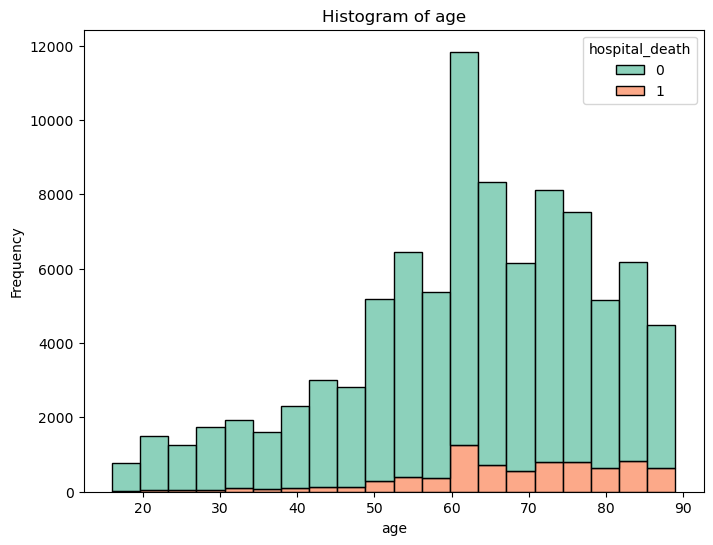

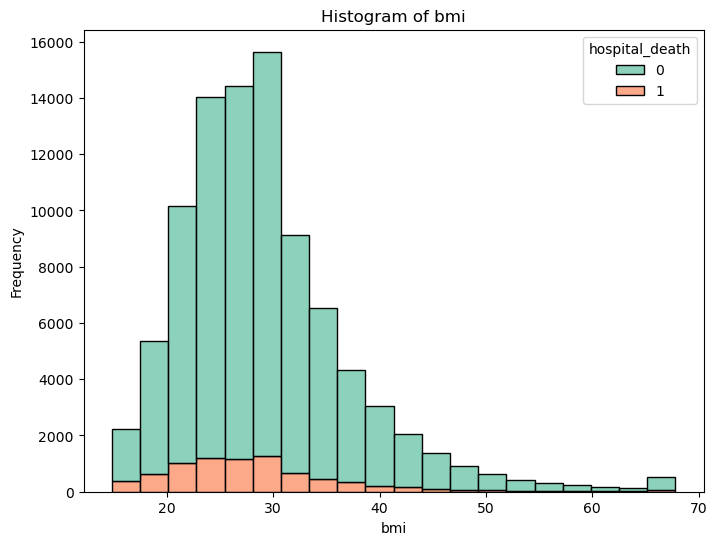

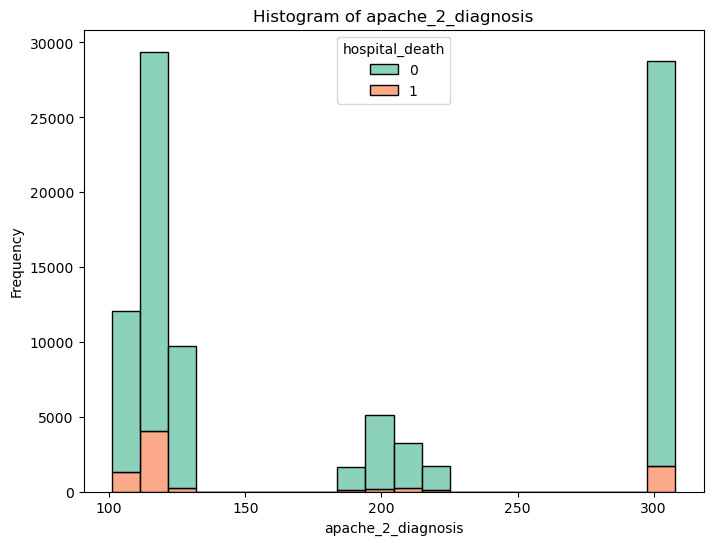

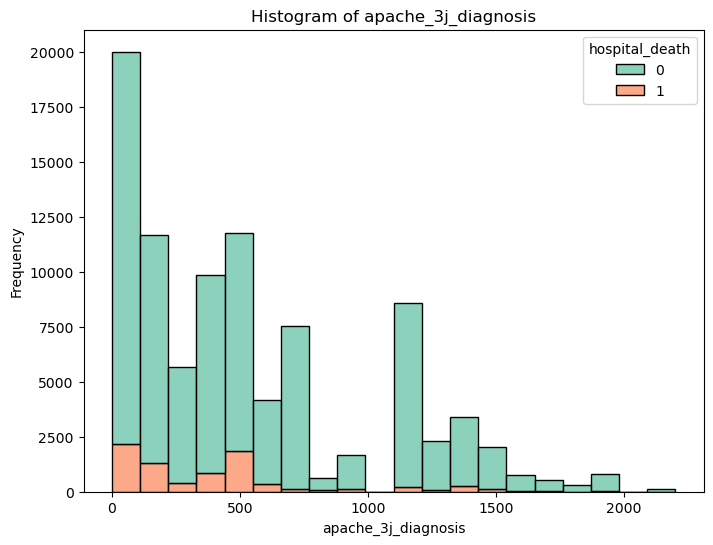

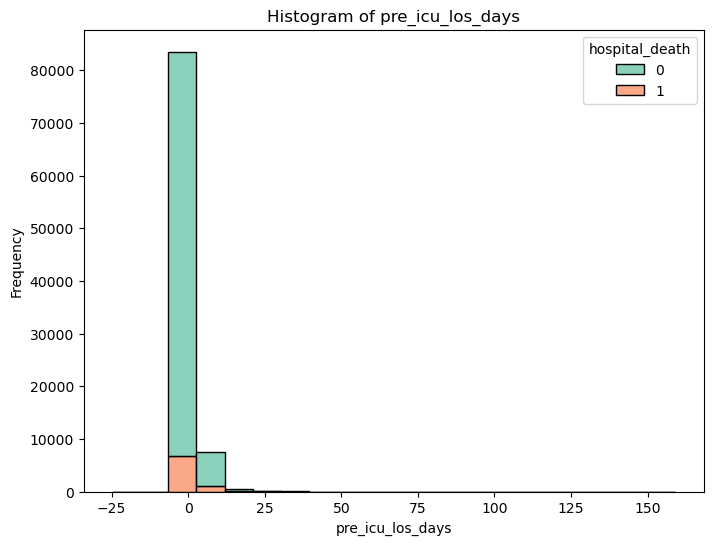

In [10]:
# check distributions of interested continuousu variable
# Create a list of variables to plot
var_cont = ['age', 'bmi', 'apache_2_diagnosis','apache_3j_diagnosis', 'pre_icu_los_days']  

# Plot histograms for each variable
for var in var_cont:
    plt.figure(figsize=(8, 6))  # Set the size of the plot area
    sns.histplot(data=Survival, x=var, bins=20, hue='hospital_death', multiple='stack', palette='Set2')  # Plot the histogram with color differentiation
    plt.title('Histogram of {}'.format(var))  # Set the title
    plt.xlabel(var)  # Set the x-axis label
    plt.ylabel('Frequency')  # Set the y-axis label
    plt.show()  # Show the histogram


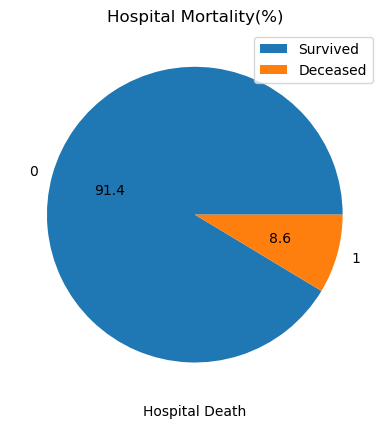

In [406]:
Survival.hospital_death.value_counts().plot(kind='pie', autopct="%.1f", title='Hospital Mortality(%)')
# Add labels
plt.ylabel('')  # Remove y-axis label
plt.xlabel('Hospital Death')  # Add x-axis label
plt.legend(labels=['Survived', 'Deceased'], loc='upper right')  

plt.show()

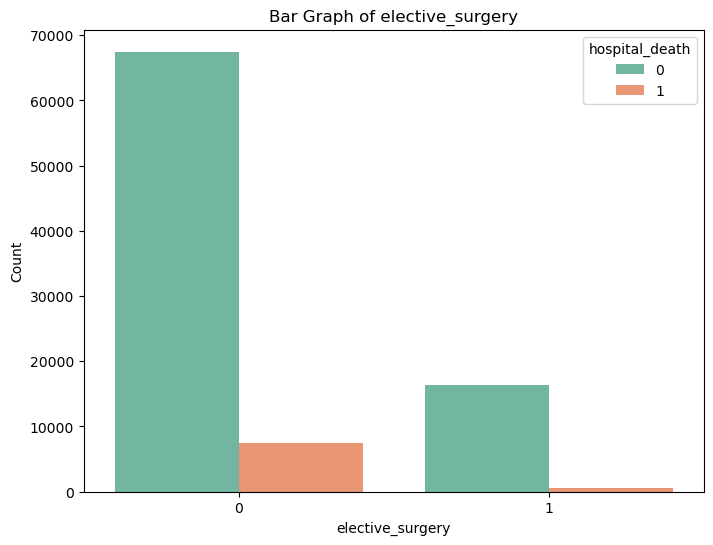

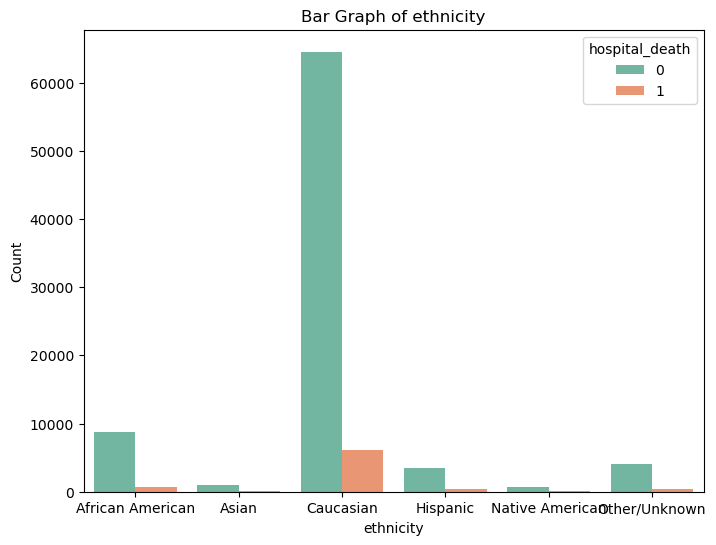

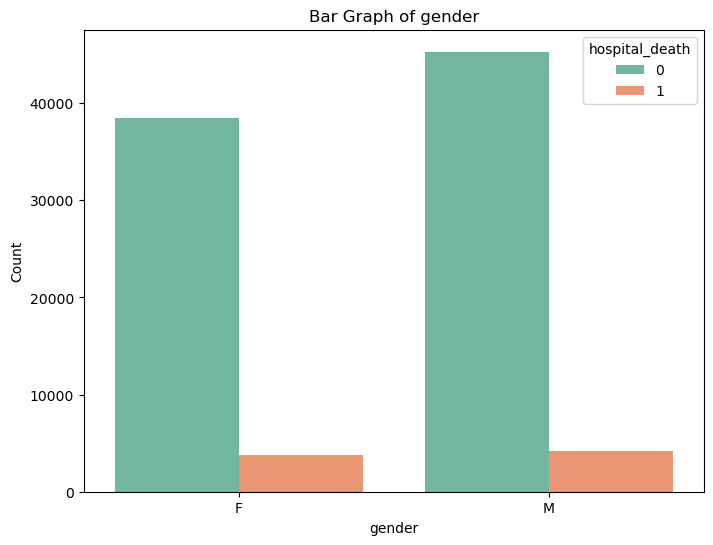

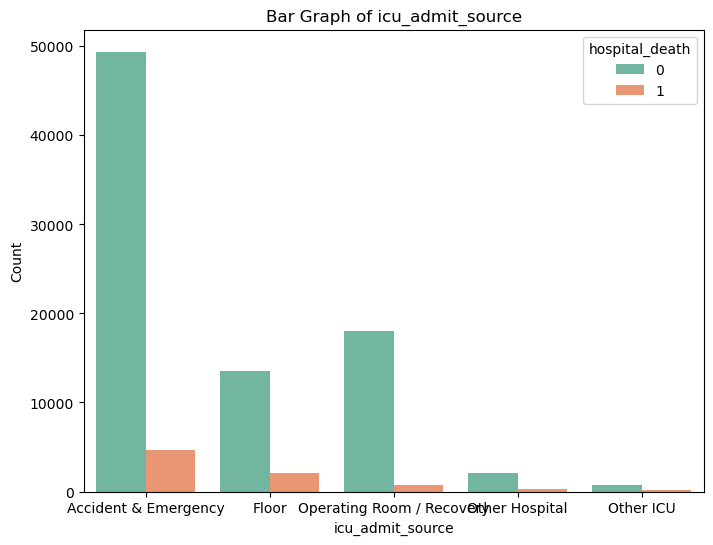

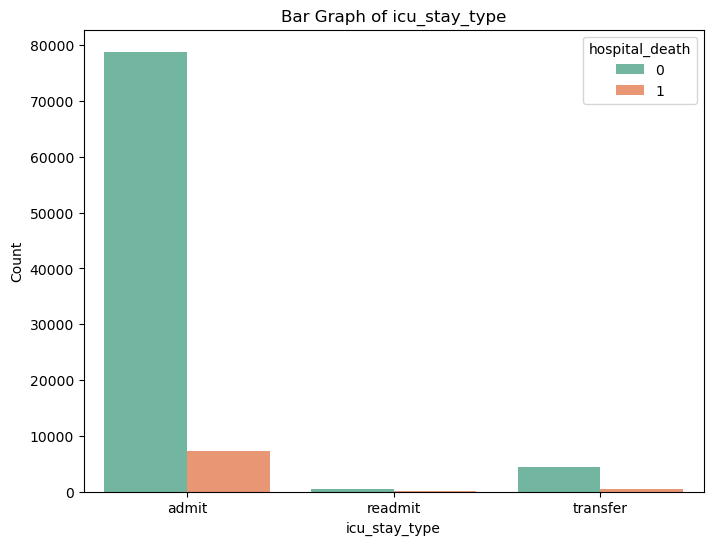

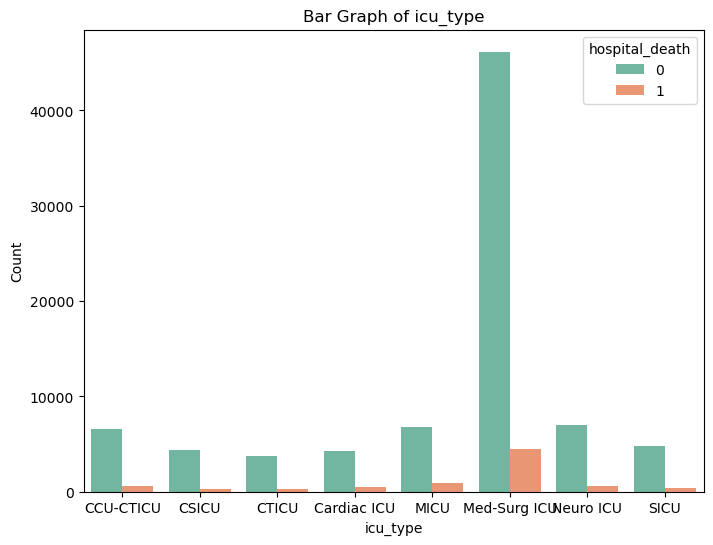

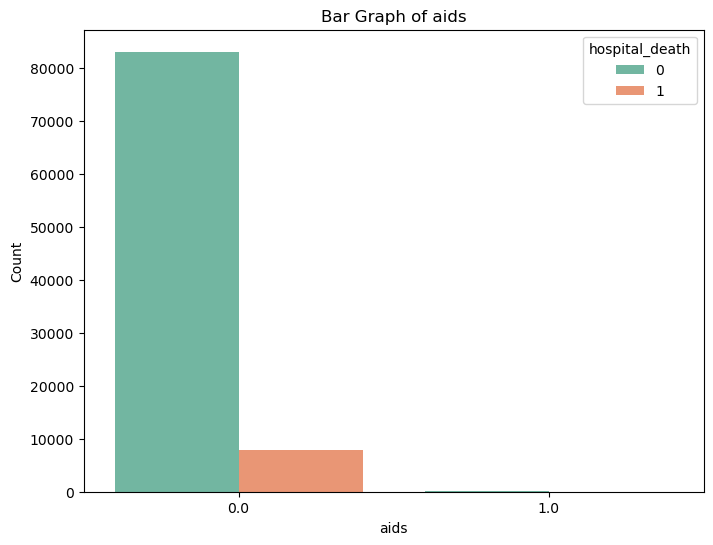

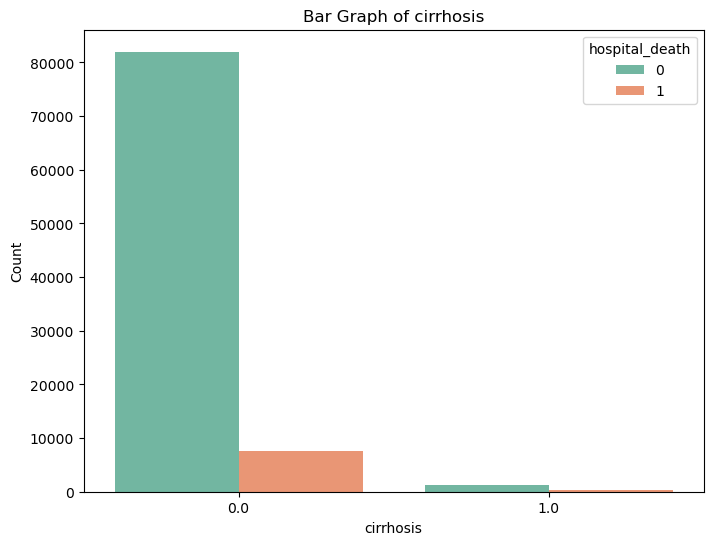

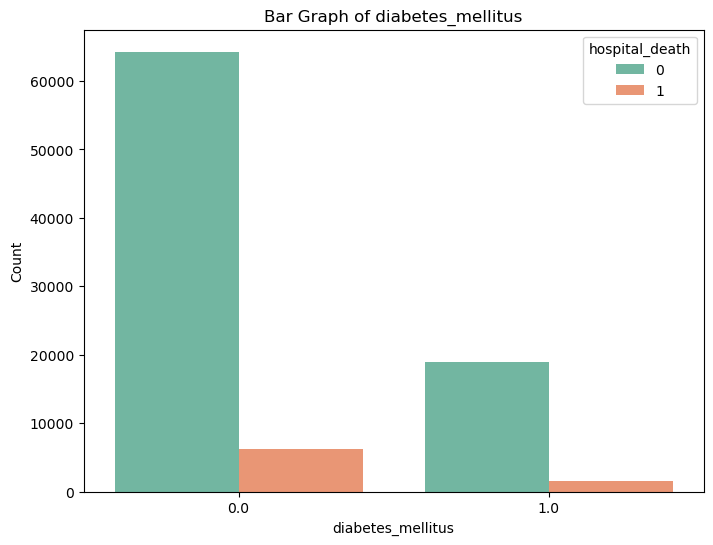

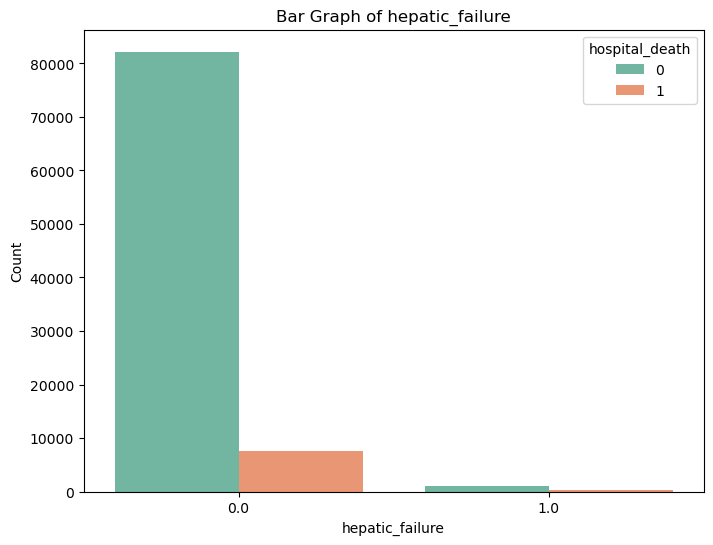

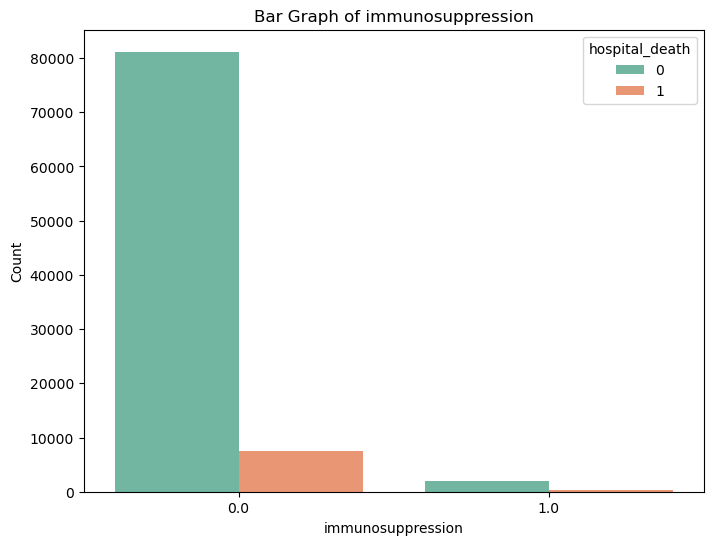

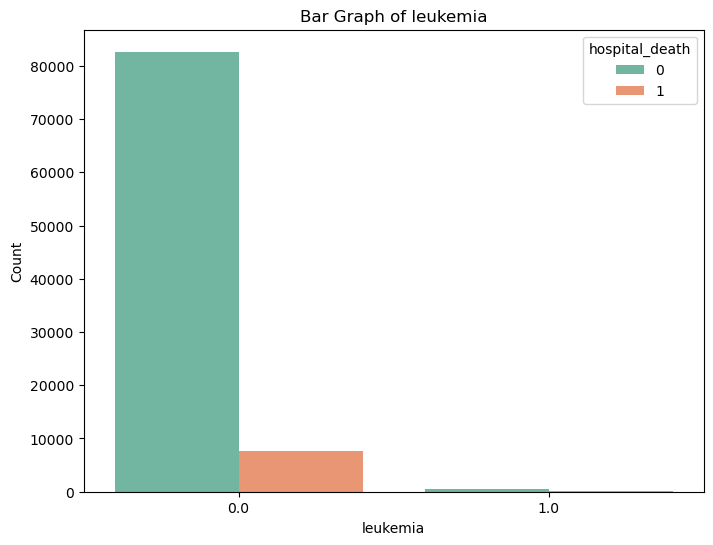

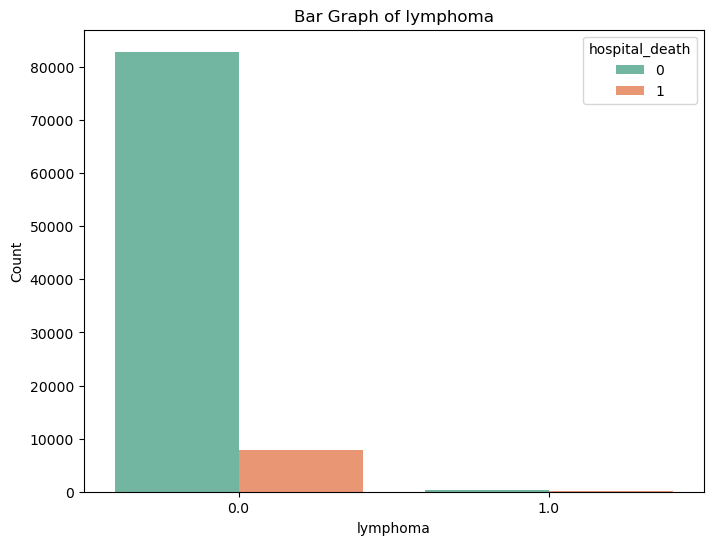

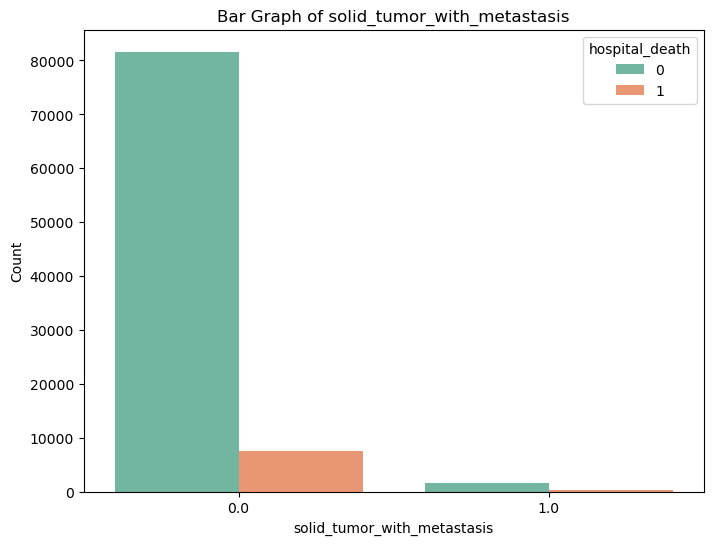

In [379]:
categorical_cols = ['elective_surgery', 'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'aids', 'cirrhosis',
                    'diabetes_mellitus','hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']  

# Plot bar graphs for each categorical variable
for var in categorical_cols:
    plt.figure(figsize=(8, 6))  # Set the size of the plot area
    sns.countplot(data=Survival, x=var, hue='hospital_death', palette='Set2')  # Plot the bar graph with color differentiation
    plt.title('Bar Graph of {}'.format(var))  # Set the title
    plt.xlabel(var)  # Set the x-axis label
    plt.ylabel('Count')  # Set the y-axis label
    plt.legend(title='hospital_death', loc='upper right')  # Add legend
    plt.show()  # Show the bar graph



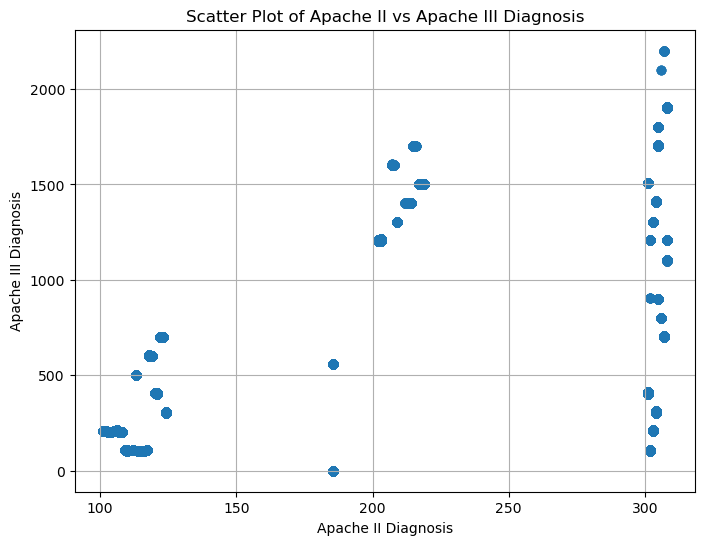

Correlation between Apache II and Apache III diagnoses: 0.39132974553118477


In [408]:
# Apache II　vs Apache III
plt.figure(figsize=(8, 6))
plt.scatter(Survival['apache_2_diagnosis'], Survival['apache_3j_diagnosis'], alpha=0.5)
plt.title('Scatter Plot of Apache II vs Apache III Diagnosis')
plt.xlabel('Apache II Diagnosis')
plt.ylabel('Apache III Diagnosis')
plt.grid(True)
plt.show()

correlation = Survival['apache_2_diagnosis'].corr(Survival['apache_3j_diagnosis'])
print("Correlation between Apache II and Apache III diagnoses:", correlation)

Apache II and Apache II do not necessarily show collinearity based on scatter plots and correlation values.

## Variable selection

In [12]:
# Variavle Selection form EDA abd privious knowledge
Survival_select = Survival[['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days',
                'apache_2_diagnosis', 'apache_3j_diagnosis', 'aids', 'cirrhosis', 'diabetes_mellitus',
				'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'hospital_death']]

In [13]:
# Exlude rows with missing value
Survival_complete =  Survival_select.dropna()

In [411]:
Survival_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89488 entries, 0 to 91712
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   age                          89488 non-null  float64 
 1   bmi                          89488 non-null  float64 
 2   elective_surgery             89488 non-null  int64   
 3   ethnicity                    89488 non-null  category
 4   gender                       89488 non-null  category
 5   icu_admit_source             89488 non-null  category
 6   icu_stay_type                89488 non-null  category
 7   icu_type                     89488 non-null  category
 8   pre_icu_los_days             89488 non-null  float64 
 9   apache_2_diagnosis           89488 non-null  float64 
 10  apache_3j_diagnosis          89488 non-null  float64 
 11  aids                         89488 non-null  float64 
 12  cirrhosis                    89488 non-null  float64 
 13  d

In [14]:
y = Survival_complete['hospital_death']
X = Survival_complete.drop(columns=['hospital_death'])
X = pd.get_dummies(X)					

In [413]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89488 entries, 0 to 91712
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         89488 non-null  float64
 1   bmi                                         89488 non-null  float64
 2   elective_surgery                            89488 non-null  int64  
 3   pre_icu_los_days                            89488 non-null  float64
 4   apache_2_diagnosis                          89488 non-null  float64
 5   apache_3j_diagnosis                         89488 non-null  float64
 6   aids                                        89488 non-null  float64
 7   cirrhosis                                   89488 non-null  float64
 8   diabetes_mellitus                           89488 non-null  float64
 9   hepatic_failure                             89488 non-null  float64
 10  immunosupp

In [95]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [96]:
# Extract column names
column_names = X_train.columns

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames
X_train = pd.DataFrame(X_train_scaled, columns=column_names)
X_test = pd.DataFrame(X_test_scaled, columns=column_names)

# Logitstic Regression

In [157]:
# Logitstic Regression
# Define and train the logistic regression model
model_log = LogisticRegression(max_iter=1000) 
model_log.fit(X_train_scaled, y_train)

# Make predictions using the test data
y_pred = model_log.predict(X_test_scaled)

In [158]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[Logistic Regression] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Logistic Regression] Confusion Matrix:
 [[24520    13]
 [ 2309     5]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9139    0.9995    0.9548     24533
           1     0.2778    0.0022    0.0043      2314

    accuracy                         0.9135     26847
   macro avg     0.5959    0.5008    0.4795     26847
weighted avg     0.8591    0.9135    0.8729     26847

Matthew's Correlation Coefficient: 0.017682177557058896


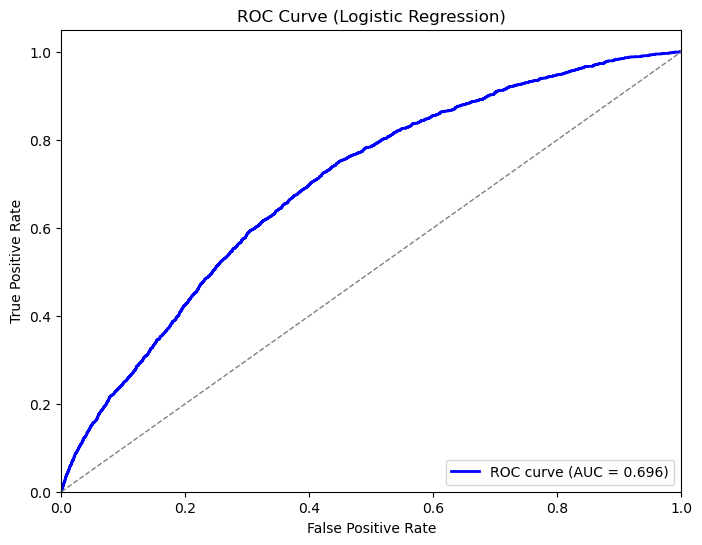

In [190]:
# Make predictions using the test data
y_pred_proba = model_log.predict_proba(X_test_scaled)[:, 1]  # Get predicted probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, thresholds= roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.show()

#### Threshold = 0.2

In [201]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[Logistic Regression (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Logistic Regression (Threshold = 0.2)] Confusion Matrix:
 [[22056  2477]
 [ 1462   852]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9378    0.8990    0.9180     24533
           1     0.2559    0.3682    0.3020      2314

    accuracy                         0.8533     26847
   macro avg     0.5969    0.6336    0.6100     26847
weighted avg     0.8791    0.8533    0.8649     26847

Matthew's Correlation Coefficient: 0.22755226346416188


## Random Forests

In [199]:
model_rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=123) 
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=123)

In [200]:
# Define the range of values for n_estimators to search
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300]}  

# Create the grid search object
grid_search = GridSearchCV(RandomForestRegressor(max_features="sqrt", random_state=123), param_grid, cv=5)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best hyperparameters to create the final model
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[Random Forest] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)


Best hyperparameters: {'n_estimators': 300}
[Random Forest] Confusion Matrix:
 [[24316   217]
 [ 2121   193]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9198    0.9912    0.9541     24533
           1     0.4707    0.0834    0.1417      2314

    accuracy                         0.9129     26847
   macro avg     0.6953    0.5373    0.5479     26847
weighted avg     0.8811    0.9129    0.8841     26847

Matthew's Correlation Coefficient: 0.1706340301319229


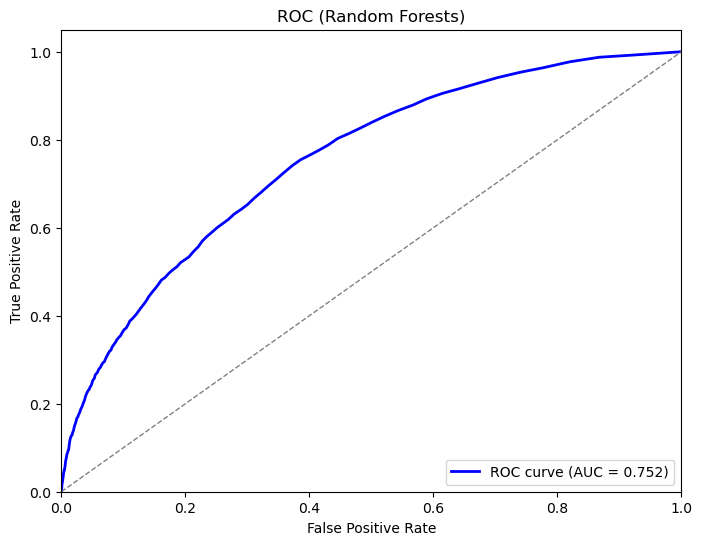

In [203]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forests)')
plt.legend(loc='lower right')
plt.show()

#### Threshold = 0.2

In [204]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[Random Forests (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Random Forests (Threshold = 0.2)] Confusion Matrix:
 [[22056  2477]
 [ 1462   852]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9378    0.8990    0.9180     24533
           1     0.2559    0.3682    0.3020      2314

    accuracy                         0.8533     26847
   macro avg     0.5969    0.6336    0.6100     26847
weighted avg     0.8791    0.8533    0.8649     26847

Matthew's Correlation Coefficient: 0.22755226346416188


## Boosting

In [205]:
# Boosting
model_boosting = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=123) 
model_boosting.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000,
                          random_state=123)

In [206]:
# Get feature importances from the trained boosting model
feature_importances = model_boosting.feature_importances_

# Create a DataFrame to store feature importances along with feature names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important predictors
print(importance_df.head(15)) # Get feature importances from the trained boosting model
feature_importances = model_boosting.feature_importances_

                                       Feature  Importance
5                          apache_3j_diagnosis    0.515049
4                           apache_2_diagnosis    0.154277
0                                          age    0.092392
3                             pre_icu_los_days    0.086148
1                                          bmi    0.033443
2                             elective_surgery    0.022422
13                 solid_tumor_with_metastasis    0.021475
9                              hepatic_failure    0.015807
7                                    cirrhosis    0.013501
23                      icu_admit_source_Floor    0.009532
24  icu_admit_source_Operating Room / Recovery    0.006124
22       icu_admit_source_Accident & Emergency    0.005206
11                                    leukemia    0.004233
34                               icu_type_MICU    0.004048
25             icu_admit_source_Other Hospital    0.003568


In [207]:
y_pred_proba = model_boosting.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[Boosting] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Boosting] Confusion Matrix:
 [[24417   116]
 [ 2154   160]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9189    0.9953    0.9556     24533
           1     0.5797    0.0691    0.1236      2314

    accuracy                         0.9154     26847
   macro avg     0.7493    0.5322    0.5396     26847
weighted avg     0.8897    0.9154    0.8839     26847

Matthew's Correlation Coefficient: 0.1792224300371397


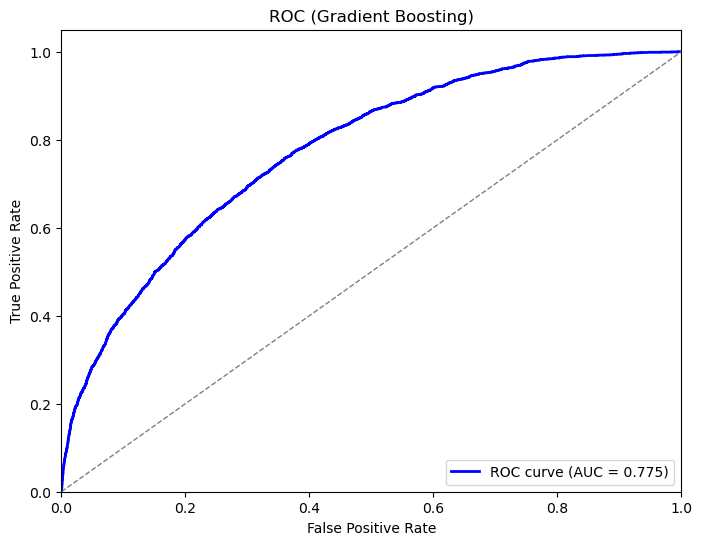

In [210]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Gradient Boosting)')
plt.legend(loc='lower right')
plt.show()

In [211]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[Gradient Boosting (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[Gradient Boosting (Threshold = 0.2)] Confusion Matrix:
 [[23333  1200]
 [ 1664   650]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9334    0.9511    0.9422     24533
           1     0.3514    0.2809    0.3122      2314

    accuracy                         0.8933     26847
   macro avg     0.6424    0.6160    0.6272     26847
weighted avg     0.8833    0.8933    0.8879     26847

Matthew's Correlation Coefficient: 0.257032131162784


## Light GBM

In [717]:
# # Define the LightGBM model
# model_lightgbm = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=123)

# # Fit the model to the training data
# model_lightgbm.fit(X_train, y_train)

NameError: name 'lgb' is not defined

## GAM

In [212]:
# Define and train the logistic regression model
model_gam = LogisticGAM().fit(X_train, y_train)

# Make predictions using the test data
y_pred = model_gam.predict(X_test)

In [213]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("[GAM] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

[GAM] Confusion Matrix:
 [[24519    14]
 [ 2303    11]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9141    0.9994    0.9549     24533
           1     0.4400    0.0048    0.0094      2314

    accuracy                         0.9137     26847
   macro avg     0.6771    0.5021    0.4821     26847
weighted avg     0.8733    0.9137    0.8734     26847

Matthew's Correlation Coefficient: 0.03848847250363991


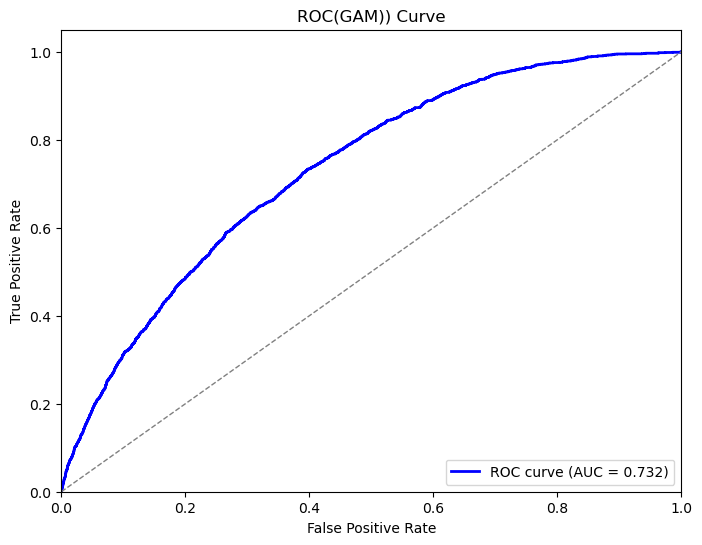

In [215]:
# Make predictions using the test data
y_pred_proba = model_gam.predict_proba(X_test)  # Get predicted probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC(GAM)) Curve')
plt.legend(loc='lower right')
plt.show()

In [216]:
threshold = 0.2

y_pred_thresholded = (y_pred_proba > threshold).astype(int)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
print("[GAM (Threshold = 0.2)] Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred_thresholded, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred_thresholded)
print("Matthew's Correlation Coefficient:", matthews_corr)

[GAM (Threshold = 0.2)] Confusion Matrix:
 [[23214  1319]
 [ 1853   461]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9261    0.9462    0.9360     24533
           1     0.2590    0.1992    0.2252      2314

    accuracy                         0.8818     26847
   macro avg     0.5925    0.5727    0.5806     26847
weighted avg     0.8686    0.8818    0.8748     26847

Matthew's Correlation Coefficient: 0.164071393195623


## Supprt Vector Machines

In [ ]:
# Define the range of values for C (regularization parameter)
param_grid = {'C': [0.1, 1, 10]} 

# When C is small, we seek narrow margins that are rarely violated; this amounts to a classifier that is highly fit to the data, which mar have low bias but high variance.

# Create the grid search object
grid_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=123), param_grid, cv=5)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'C': 0.1}


In [70]:
# Use the best hyperparameters to create the final model
model_svm = grid_search.best_estimator_
y_pred = model_svm.predict(X_test)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", class_report)

# Model evaluation
matthews_corr = matthews_corrcoef(y_test, y_pred)
print("Matthew's Correlation Coefficient:", matthews_corr)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

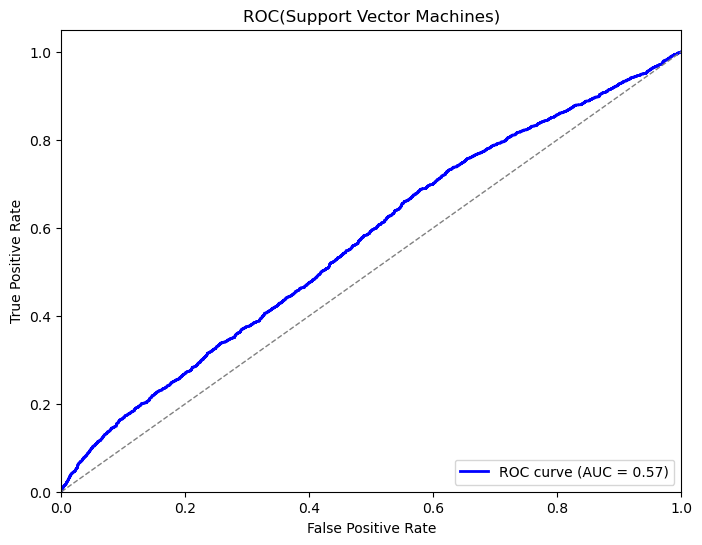

In [ ]:
# Make predictions using the test data
y_pred_proba = model_svm.predict_proba(X_test)[:, 1]    # Get predicted probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute area under the ROC curve (AUC)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC(Support Vector Machines)')
plt.legend(loc='lower right')
plt.show()

## Deep Learning

In [217]:
# Split the data into training and test sets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X.to_numpy(), 
                                                    y.to_numpy(), 
                                                    test_size=0.30, 
                                                    random_state=123)

In [218]:
# scaling
X_train_dl = scaler.fit_transform(X_train_dl)
X_test_dl = scaler.fit_transform(X_test_dl)

In [489]:
# Create a dataset class called WisconsinDataset
class SurvivalDataset(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32
    self.X = torch.from_numpy(X_train.astype(np.float32))
    # Convert int64 to float32 and apply the
    # unsqueeze function to create an output vector with consistent dimensions .unsqueeze(1): adds an additional dimension (of size 1) to the tensor
    self.y = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
    self.len = self.X.shape[0]

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [490]:
# Instantiate the training data 
traindata = SurvivalDataset(X_train_dl, y_train_dl)

print(traindata[0])
print(len(traindata))

(tensor([ 0.2206,  0.4060, -0.4774,  0.4649,  1.3647, -0.9720, -0.0320, -0.1250,
        -0.5403, -0.1155, -0.1645, -0.0856, -0.0657, -0.1473, -0.3438, -0.1127,
         0.5272, -0.2090, -0.0957, -0.2253, -0.9235,  0.9235, -1.2026,  2.1998,
        -0.5083, -0.1616, -0.0824,  0.2500, -0.0787, -0.2357, -0.2930, -0.2316,
        -0.2165, -0.2342,  3.2724, -1.0953, -0.3021, -0.2500]), tensor([1.]))
62641


In [585]:
# Instantiate the dataloader object
batch_size = 10
trainloader = DataLoader(traindata, batch_size=batch_size)
#  The batch size specifies the number of training samples processed by the model in one go.

In [586]:
# Set the number of features (len of X cols)
input_dim = X_train_dl.shape[1]

# Set the number of hidden layers
hidden_layer_dim1 = 15
hidden_layer_dim2 = 10
hidden_layer_dim3 = 5

# Set the number of classes
output_dim = 1

# Set the dropput prob
dropout_prob = 0.5

In [540]:
# Define the Neural Network class
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden_layer_dim1, hidden_layer_dim2, hidden_layer_dim3, output_dim, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layer_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_layer_dim1, hidden_layer_dim2)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_layer_dim2, hidden_layer_dim3)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.linear4 = nn.Linear(hidden_layer_dim3, output_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.linear4(x))
        return x

In [599]:
# Set a random seed for reproducibility
torch.manual_seed(123);

# Instantiate the Neural Network class. We have to repeat everytime when run new code
clf = NeuralNetwork(input_dim, hidden_layer_dim1, hidden_layer_dim2, hidden_layer_dim3, output_dim, dropout_prob)

# Print out details about the layers of the model
print(clf.parameters)

<bound method Module.parameters of NeuralNetwork(
  (linear1): Linear(in_features=38, out_features=15, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=15, out_features=10, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=10, out_features=5, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=5, out_features=1, bias=True)
)>


In [600]:
# Define the loss function
# loss_function = nn.BCELoss()

weight = torch.tensor([15]) # weight more on the positive outcome
loss_function = nn.BCEWithLogitsLoss(pos_weight=weight)

In [601]:
# Set the optimzer as Stochastic Gradient Descent
weight_decay = 0.001 
optimizer = torch.optim.SGD(clf.parameters(), lr=0.0005 , weight_decay=weight_decay)

In [602]:
# Set the number of epochs
epochs = 30

In [603]:
# Define correct and total variables that are initially set to zero
# These variables are used to compute the training accuracy
correct, total = 0, 0

# Define empty list variables that store the losses and accuracies at each epoch
losses = []
accuracies = []

# Loop over the number of epochs
for epoch in range(epochs):
    # Iterate over the minibatches in the trainloader
    for data in trainloader:
        # Get the input and target values in the minibatch
        inputs, targets = data
        # Forward propagation step
        outputs = clf(inputs)
        # Compute the loss
        loss = loss_function(outputs, targets)
        # Compute prediction, anything greater than 0.5 is rounded up to 1, less than 0.5 rounded down to 0
        predicted = torch.round(outputs.data)
        ## round values to the nearest integer, converts the continuous predictions into binary class labels (0 or 1).
        total += targets.size(0)
        ## incremented by the number of samples in the current batch.
        correct += (predicted == targets).sum().item()
        ## calculates the number of correct predictions in the current batch and updates the total count of correct predictions. 
       
        # Zero out previous epoch gradients
        optimizer.zero_grad() 
        # Backward propagation
        loss.backward() 
        # Update model parameters 
        optimizer.step()
    # Compute accuracy    
    acc = correct / total
    
    losses.append(loss.item())
    accuracies.append(acc)
    print("epoch {}  loss : {:.5f}  accuracy : {:.5f}".format(epoch, loss, acc))

epoch 0  loss : 1.00934  accuracy : 0.13831
epoch 1  loss : 1.01205  accuracy : 0.19666
epoch 2  loss : 0.97365  accuracy : 0.27195
epoch 3  loss : 0.94724  accuracy : 0.33751
epoch 4  loss : 0.97711  accuracy : 0.40909
epoch 5  loss : 0.97909  accuracy : 0.47869
epoch 6  loss : 0.96538  accuracy : 0.53799
epoch 7  loss : 0.95553  accuracy : 0.58452
epoch 8  loss : 0.90336  accuracy : 0.62100
epoch 9  loss : 0.94568  accuracy : 0.65024
epoch 10  loss : 0.94805  accuracy : 0.67419
epoch 11  loss : 0.93508  accuracy : 0.69414
epoch 12  loss : 0.94258  accuracy : 0.71104
epoch 13  loss : 0.93806  accuracy : 0.72552
epoch 14  loss : 0.94467  accuracy : 0.73808
epoch 15  loss : 0.93390  accuracy : 0.74906
epoch 16  loss : 0.93115  accuracy : 0.75875
epoch 17  loss : 0.87872  accuracy : 0.76736
epoch 18  loss : 0.87826  accuracy : 0.77507
epoch 19  loss : 0.87690  accuracy : 0.78201
epoch 20  loss : 0.93363  accuracy : 0.78828
epoch 21  loss : 0.93102  accuracy : 0.79399
epoch 22  loss : 0.8

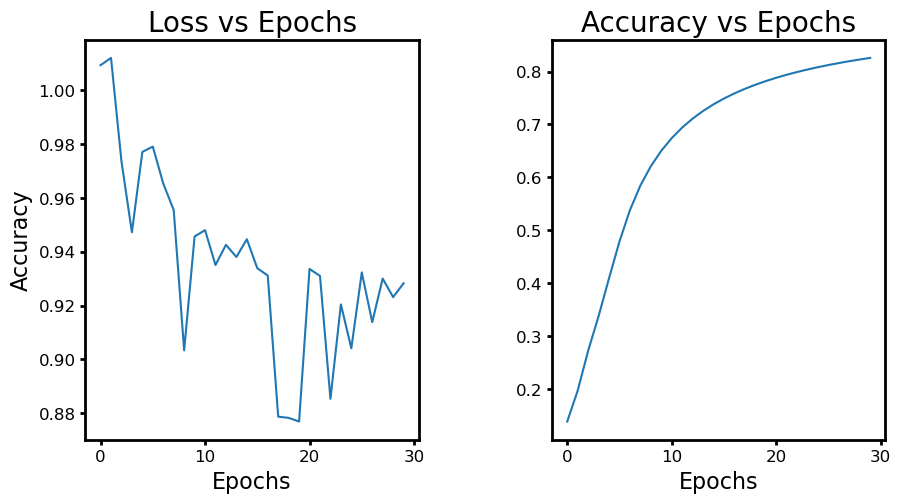

In [604]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
# Adjust figure and axes properties
fig.set_size_inches(10, 5)
ax1.spines[['top','bottom','left','right']].set_linewidth(2)
ax1.tick_params(width=2, labelsize=12)
ax2.spines[['top','bottom','left','right']].set_linewidth(2)
ax2.tick_params(width=2, labelsize=12)

# Give the plot title and axis labels
ax1.plot(losses)
ax1.set_title('Loss vs Epochs', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax2.plot(accuracies)
ax2.set_title('Accuracy vs Epochs', fontsize=20)
ax2.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)

# Adjust the subplots to look nice
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# Display the plot
plt.show()

### Test the model

In [605]:
testdata = SurvivalDataset(X_test_dl, y_test_dl)
testloader = DataLoader(testdata, batch_size=batch_size)

In [606]:
correct, total = 0, 0
predicted_labels = []
true_labels = []

# no need to calculate gradients when making predictions
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # calculate output by running through the network
        outputs = clf(inputs)
        # get the predictions
        predicted = torch.round(outputs.data)
        
        # update results
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # collect predicted and true labels for evaluation
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Compute accuracy
accuracy = 100 * correct / total

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Display the classification report
class_report = classification_report(true_labels, predicted_labels, digits=4)
print("Classification Report:\n", class_report)

# Compute precision, F1 score, and Matthew coefficient
f1 = f1_score(true_labels, predicted_labels)
matthew = matthews_corrcoef(true_labels, predicted_labels)

print("Matthew Correlation Coefficient: {:.4f}".format(matthew))


Confusion Matrix:
 [[24493    40]
 [ 2305     9]]
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9140    0.9984    0.9543     24533
         1.0     0.1837    0.0039    0.0076      2314

    accuracy                         0.9127     26847
   macro avg     0.5488    0.5011    0.4810     26847
weighted avg     0.8510    0.9127    0.8727     26847

Matthew Correlation Coefficient: 0.0149


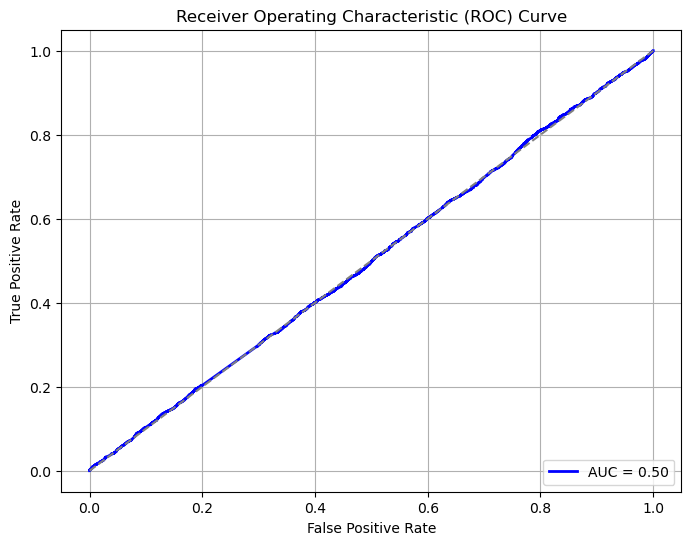

AUC Score: 0.5006244829737562


In [569]:
# Calculate predicted probabilities
predicted_probabilities = []
true_labels = []

# Iterate over testloader to get predictions and true labels
with torch.no_grad():
    for inputs, labels in testloader:
        # Forward pass
        outputs = clf(inputs)
        # Convert output probabilities to predicted labels
        predicted_probabilities.extend(outputs.numpy())
        true_labels.extend(labels.numpy())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

# Compute AUC score
auc_score = roc_auc_score(true_labels, predicted_probabilities)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC score
print(f'AUC Score: {auc_score}')

In [ ]:
### Deep Learning (Ver2; include )